In [20]:
# Import Libraries 
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import Libraries for Unsupervised Learning on Tabular Data
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # Standardize features by removing the mean and scaling to unit variance
from sklearn.pipeline import make_pipeline

import spot_creds
import spotipy

In [21]:
# Create a function to load the data from two csv files and concatenate them
def load_data():
    # Load the data from the two csv files
    data1 = pd.read_csv('data/song_tables/SpotifyAudioFeaturesApril2019.csv')
    data2 = pd.read_csv('data/song_tables/SpotifyAudioFeaturesNov2018.csv')
    # Concatenate the two dataframes
    data = pd.concat([data1, data2], axis=0)
    return data

df = load_data()
df.head()



,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [22]:
# Preprocess the data
def preprocess_data(df):
    df = df.dropna()
    numeric_df = df.drop(['track_id', 'track_name', 'artist_name'], axis=1)
    scaler = StandardScaler()
    pp_df = scaler.fit_transform(numeric_df)
    return pp_df, df, scaler

pp_df, original_df, scaler = preprocess_data(df)

# Fit the KMeans model
def fit_kmeans(df, n_clusters):
    model = KMeans(n_clusters=n_clusters)
    model.fit(df)
    return model

model = fit_kmeans(pp_df, 10)


c:\Users\i.lutticken\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


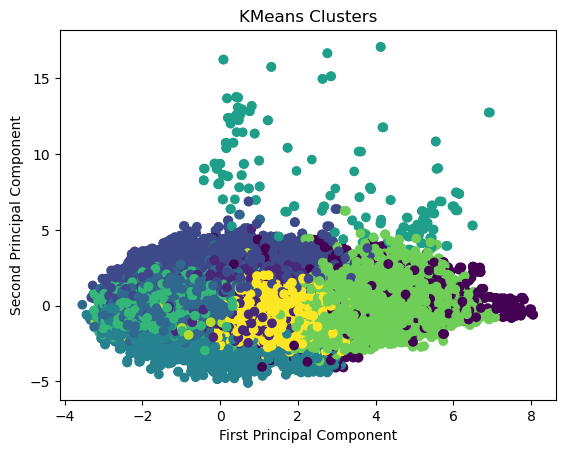

In [23]:
# Visualize the clusters
def visualize_clusters(df, model):
    pca = PCA(n_components=2)
    pc = pca.fit_transform(df)
    plt.scatter(pc[:, 0], pc[:, 1], c=model.labels_)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('KMeans Clusters')
    plt.show()

visualize_clusters(pp_df, model)

In [24]:
# Show a sample of songs from each cluster
def show_cluster_samples(df, model, n_samples):
    df['cluster'] = model.labels_
    for cluster in range(model.n_clusters):
        print(f'Cluster {cluster}:')
        sample = df[df['cluster'] == cluster].sample(n=n_samples)
        print(sample[['track_name', 'artist_name', 'popularity']])
        print('\n')

show_cluster_samples(original_df, model, 3)


Cluster 0:
         track_name   artist_name  popularity
61344      Champion    Blaine boy           1
107181  Rank & File  Moses Sumney          40
65954       Growing          Hanz          18


Cluster 1:
                         track_name         artist_name  popularity
29800  Genesis of Precious Thoughts     Tangerine Dream          22
34588                No More Speech     Plattenschieber           0
11899           700 on Tennis Shoes  Neighborhood Crook           0


Cluster 2:
                                      track_name    artist_name  popularity
81904                                 Good Times         Styles          24
103628  Challenger (ASOT 876) [Progressive Pick]       Sodality          16
79898                      The One That You Love  Comanche Moon           5


Cluster 3:
                    track_name    artist_name  popularity
53112             So wie jetzt   Revolverheld          42
111060                 Perfect  Kidz Bop Kids          49
106918  Favorite

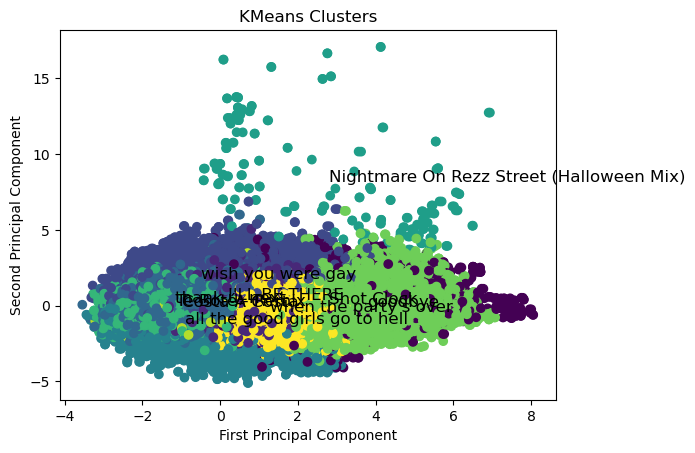

In [25]:
# Visualize clusters with most popular songs
def visualize_clusters_with_songs(df, original_df, model):
    pca = PCA(n_components=2)
    pc = pca.fit_transform(df)
    plt.scatter(pc[:, 0], pc[:, 1], c=model.labels_)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('KMeans Clusters')
    for cluster in range(model.n_clusters):
        cluster_indices = np.where(model.labels_ == cluster)[0]
        cluster_center = pc[cluster_indices].mean(axis=0)
        popular_song = original_df[original_df['cluster'] == cluster].sort_values('popularity', ascending=False).iloc[0]
        plt.text(cluster_center[0], cluster_center[1], popular_song['track_name'], fontsize=12)
    plt.show()

# Add 'cluster' column to the original dataframe
original_df['cluster'] = model.labels_
visualize_clusters_with_songs(pp_df, original_df, model)

In [26]:
# Recommend a song from a given cluster
def recommend_songs(df, model, cluster):
    indices = np.where(df['cluster'] == cluster)[0]
    songs = df.iloc[indices]
    song = songs.sample()
    return song[['track_name', 'artist_name', 'popularity']]

# Recommend a song from cluster 0
print(recommend_songs(original_df, model, 0))

                               track_name            artist_name  popularity
98807  Dank sei Gott in der Höhe, BWV 287  Johann Sebastian Bach          18


In [28]:
# Recommend a song based on a given song from the model
def recommend_song(df, model, song_name):
    song = df[df['track_name'] == song_name].iloc[0]
    # Ensure we drop the same columns that were dropped during preprocessing
    song_features = song.drop(['track_id', 'track_name', 'artist_name', 'cluster']) # 'popularity'
    # Convert to DataFrame with appropriate column names
    song_features_df = pd.DataFrame([song_features], columns=song_features.index)
    song_features_scaled = scaler.transform(song_features_df)
    cluster = model.predict(song_features_scaled)[0]
    return recommend_songs(df, model, cluster)

# Recommend a song based on 'Shape of You' by Ed Sheeran
print(recommend_song(original_df, model, 'Breath'))

       track_name artist_name  popularity
92880  Wolf Totem      The HU          52


In [29]:
# Load Spotify credentials
client_id = spot_creds.client_id
client_secret = spot_creds.client_secret


In [30]:
# Pull audio features for a given song from Spotify and return them in a format that can be used by the model
def get_audio_features(track_name, artist_name, client_id, client_secret):
    # Initialize Spotipy client
    sp = spotipy.Spotify(client_credentials_manager=spotipy.oauth2.SpotifyClientCredentials(client_id, client_secret))
    # Search for the track
    results = sp.search(q=f'track:{track_name} artist:{artist_name}', type='track', limit=1)
    # Get the track ID
    track_id = results['tracks']['items'][0]['id']
    # Get the audio features
    audio_features = sp.audio_features(track_id)[0]
    # Get the popularity
    popularity = results['tracks']['items'][0]['popularity']
    # Convert the audio features and popularity to a DataFrame
    audio_features_df = pd.DataFrame([audio_features])
    audio_features_df['popularity'] = popularity
    # Drop irrelevant columns
    audio_features_df = audio_features_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url'], axis=1)
    # Rearrange columns to match the original DataFrame
    audio_features_df = audio_features_df[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'popularity']]
    return audio_features_df

# Get audio features for 'With or Without You' by U2
audio_features = get_audio_features('With or Without You', 'U2', client_id, client_secret)
print(audio_features)

   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0      0.000202          0.54       295516   0.429             0.355    2   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0     0.141   -11.822     1       0.0285  110.171               4    0.113   

   popularity  
0          74  


In [31]:
 # Recommend a song based on the new song 'With or Without You' by U2
def recommend_song_from_audio_features(df, model, audio_features, scaler):
    # Scale the audio features
    audio_features_scaled = scaler.transform(audio_features)
    # Predict the cluster
    cluster = model.predict(audio_features_scaled)[0]
    return recommend_songs(df, model, cluster)

# Recommend a song based on 'With or Without You' by U2
print(recommend_song_from_audio_features(original_df, model, audio_features, scaler))


       track_name artist_name  popularity
102657  Bajo Cero         Sky          69


In [ ]:
# Cheese